# Diffusion Benchmark

FiPy implementation of diffusion in 2D

**Do not edit `diffusion.py`**. Generate the batch-runnable file from the notebook with
```bash
jupyter nbconvert diffusion.ipynb --to python --output-dir=../scripts/
```

## Import Python modules

In [1]:
import argparse
import json
import os
import re
import sys

import fipy as fp
from fipy.tools import numerix as nmx
from fipy.tools import parallelComm

Jupyter notebook handles some things differently than from the commandline

In [2]:
try:
    from IPython import get_ipython
    isnotebook = get_ipython() is not None
except:
    isnotebook = False

## Initialize
### Load parameters

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--output", help="directory to store results in",
                    default=os.getcwd())
parser.add_argument("--store_by_solver",
                    help="store results in nested subdirectories based on solver,"
                    "preconditioner, and system size",
                    action='store_true')
parser.add_argument("--restart", help="solution to initialize from",
                    default=None)
parser.add_argument("--checkpoint_interval", help="frequency to save results",
                    type=float, default=1.)
parser.add_argument("--totaltime", help="duration of full simulation",
                    type=float, default=1.)
parser.add_argument("--numberOfElements", help="number of total cells in a Grid2D",
                    type=int, default=1000000)
parser.add_argument("--solver", help="solver class to use",
                    choices=("pcg", "cgs", "gmres", "lu"), default="pcg")
parser.add_argument("--preconditioner", help="preconditioner class to use",
                    choices=("jacobi", "ilu", "ssor", "icc", "none"), default="none")
parser.add_argument("--sweeps", help="number of nonlinear sweeps to take",
                    type=int, default=5)
parser.add_argument("--iterations", help="maximum number of linear iterations to take for each sweep",
                    type=int, default=1000)
parser.add_argument("--tolerance", help="linear solver tolerance",
                    type=float, default=1e-10)
parser.add_argument("--left", help="value of left-hand Dirichlet condition",
                    type=float, default=1.)
parser.add_argument("--right", help="value of right-hand Dirichlet condition",
                    type=float, default=0.)
parser.add_argument("--store_matrix",
                    help="store the matrix and RHS vector along with other output",
                    action='store_true')

_StoreTrueAction(option_strings=['--store_matrix'], dest='store_matrix', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='store the matrix and RHS vector along with other output', metavar=None)

### Set any parameters for interactive notebook

In [62]:
if isnotebook:
    # argv = ["--numberOfElements=10000", "--totaltime=1.2", "--checkpoint_interval=0.12",
    #         "--nucleation_scale=100", "--output=nucleation6"]
    # argv = ["--numberOfElements=1000000", "--output=diffusion01",
    #        "--store_matrix"]
    
    argv = ["--numberOfElements=16",
    "--output=diffusion04",
    "--restart=matrices/initial_conditions/diffusion/t=0.0.npz",
    "--store_matrix",
    "--totaltime=6"]
else:
    argv = None

In [63]:
args, unknowns = parser.parse_known_args(args=argv)

### Initialize mesh and solution variables

Either restart from some `path/to/restart/t={time}.npz`, where the time is assigned to `elapsed`

or

Create a mesh based on parameters. The default is a 1 x 1 domain subdivided into 1000 cells in each direction.

In [64]:
nx = ny = int(nmx.sqrt(args.numberOfElements))
mesh = fp.Grid2D(nx=nx, Lx=1., ny=ny, Ly=1.)
phi = fp.CellVariable(mesh=mesh, name="$\phi$", value=1., hasOld=True)
elapsed = 0.

In [65]:
if args.restart is not None:
    data = nmx.load(args.restart)
    lower, upper = int((1000 - nx) / 2), int((1000 + nx) / 2)
    phi.setValue(data["phi"][lower:upper, lower:upper].flat)

    # scanf("%g") simulator
    # https://docs.python.org/3/library/re.html#simulating-scanf
    scanf_g = "[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"
    pattern = ".*t=({g})\.npz".format(g=scanf_g)
    elapsed = float(re.match(pattern, args.restart).group(1))

In [66]:
x, y = mesh.cellCenters[0], mesh.cellCenters[1]
X, Y = mesh.faceCenters[0], mesh.faceCenters[1]

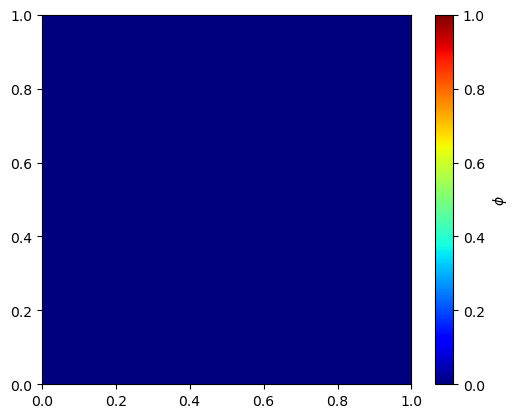

<Figure size 640x480 with 0 Axes>

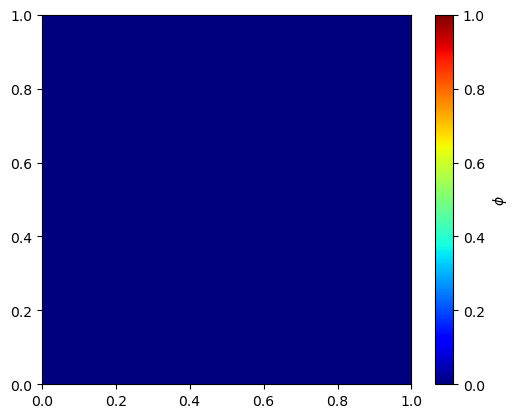

In [67]:
if isnotebook:
    viewer = fp.Viewer(vars=phi, datamin=0., datamax=1.)
    viewer.plot()

## Create solver

In [53]:
precon = None

if args.preconditioner == "jacobi":
    precon = fp.JacobiPreconditioner()
elif args.preconditioner == "ilu":
    precon = fp.ILUPreconditioner()
elif args.preconditioner == "ssor":
    precon = fp.SSORPreconditioner()
elif args.preconditioner == "icc":
    precon = fp.ICPreconditioner()
elif args.preconditioner == "none":
    precon = None

if args.solver == "cgs":
    solver_class = fp.LinearCGSSolver
elif args.solver == "gmres":
    solver_class = fp.LinearGMRESSolver
elif args.solver == "lu":
    if args.preconditioner != "none":
        # preconditioned lu doesn't make any sense
        exit()

    solver_class = fp.LinearLUSolver
elif args.solver == "pcg":
    solver_class = fp.LinearPCGSolver

solver = solver_class(tolerance=args.tolerance, criterion="initial",
                      iterations=args.iterations, precon=precon)

## Define governing equation

We solve the non-linear diffusion equation
\begin{align}
\frac{\partial\phi}{\partial t} = \nabla\cdot\left(\phi\nabla\phi\right)
\end{align}

In [54]:
eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=phi)

with boundary conditions
\begin{align}
\phi|_{x=0} &= \phi_\text{left}
\\
\phi|_{x=1} &= \phi_\text{right}
\\
\hat{n}\cdot\left(\phi\nabla\phi\right)|_{y=0} &= 0
\\
\hat{n}\cdot\left(\phi\nabla\phi\right)|_{y=1} &= 0
\end{align}

In [55]:
phi.constrain(args.left, where=mesh.facesLeft)
phi.constrain(args.right, where=mesh.facesRight)

## Setup output

### Setup ouput storage

In [56]:
if (args.output is not None) and (parallelComm.procID == 0):
    if args.store_by_solver:
        suite = solver.__module__.split('.')[2]
        if args.preconditioner is None:
            preconditioner_name = "none"
        else:
            preconditioner_name = precon.__class__.__name__
        path = os.path.join(args.output, suite,
                            solver.__class__.__name__,
                            preconditioner_name,
                            str(nx * ny))
    else:
        path = args.output

    os.makedirs(path)

if parallelComm.procID == 0:
    print("storing results in {0}".format(path))

storing results in diffusion03


### Define output routines

In [57]:
def savePhi(elapsed):
    phi_value = phi.globalValue.reshape((nx, ny))
    if parallelComm.procID == 0:
        fname = os.path.join(path, "t={}.npz".format(elapsed))
        nmx.savez(fname, phi=phi_value)

def saveMatrix(elapsed):
    mtxname = os.path.join(path, "t={}.mtx".format(elapsed))
    eq.matrix.exportMmf(mtxname)
    
    rhs_value = eq.RHSvector
    if parallelComm.procID == 0:
        rhsname = os.path.join(path, "t={}.rhs.npz".format(elapsed))
        nmx.savez(rhsname, rhs=rhs_value)

def checkpoint_data(elapsed, store_matrix=False):
    savePhi(elapsed)
    if store_matrix:
        saveMatrix(elapsed)

### Output initial condition

### Figure out when to save

In [58]:
checkpoints = (fp.numerix.arange(int(elapsed / args.checkpoint_interval),
                                 int(args.totaltime / args.checkpoint_interval))
               + 1) * args.checkpoint_interval

checkpoints.sort()

In [59]:
checkpoint_data(elapsed)

## Solve and output

In [60]:
times = checkpoints.copy()
times.sort()
times = times[(times > elapsed) & (times <= args.totaltime)]

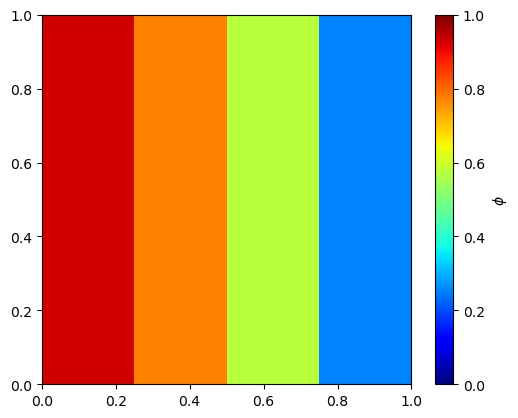

In [61]:
from steppyngstounes import CheckpointStepper, FixedStepper

eq.cacheMatrix()
eq.cacheRHSvector()

phi.updateOld()
for checkpoint in CheckpointStepper(start=elapsed,
                                    stops=times,
                                    stop=args.totaltime):

    for step in FixedStepper(start=checkpoint.begin,
                             stop=checkpoint.end,
                             size=1.):

        state = dict(state="START", numberOfElements=mesh.numberOfCells, sweeps=args.sweeps)
        if precon is None:
            state["preconditioner"] = None
        else:
            state["preconditioner"] = precon.__class__.__name__

        solver._log.debug(json.dumps(state))

        for sweep in range(args.sweeps):
            res = eq.sweep(var=phi, dt=step.size, solver=solver)

        state["state"] = "END"
        solver._log.debug(json.dumps(state))

        phi.updateOld()

        _ = step.succeeded(error=res / 1e-3)

    if checkpoint.end in checkpoints:
        checkpoint_data(checkpoint.end, store_matrix=args.store_matrix)

    if isnotebook:
        viewer.plot()

    _ = checkpoint.succeeded()